This is the simple mock galaxy catalog made of randomly shaped and placed galaxies for testing purposes

In [1]:
import ngmix
from ngmix.medsreaders import NGMixMEDS
import numpy as np
import os
import time
from astropy.table import Table, vstack, hstack


import numpy as np
import pandas as pd

import sklearn.neighbors as neighbors

from importlib import reload
import copy
import synthetic.render.generator as gen

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import multiprocessing as mp

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

import synthetic.render.render as render
import synthetic.render.icl as icl
import synthetic.render.frame as frame

import images
import meds
import subprocess
import psfex

In [2]:
def toflux(mag):
    flux = 10**((mag - 30)/-2.5)
    return flux

In [4]:
np.random.seed(5000)
nobjects = 600
canvas_size = 2000
padding = 50
mock_catalog = pd.DataFrame()


# x = np.linspace(201, 4700, 20) + 500
# y = np.linspace(201, 4700, 20) + 500
# xx, yy = np.meshgrid(x, y)
# xx = xx.flatten()
# yy = yy.flatten()


# this is something of an artifact, the X, Y is starting at 0, not at the image center... might need to be fixed
mock_catalog["X"] = np.random.uniform(padding, canvas_size - padding, size=nobjects) + canvas_size / 2
mock_catalog["Y"] = np.random.uniform(padding, canvas_size - padding, size=nobjects) + canvas_size / 2
lsizes = np.random.normal(loc=0.4, scale=0.2, size=nobjects)
mock_catalog["TSIZE"] = 10**(lsizes - 1) * 20
mock_catalog["FRACDEV"] = np.random.uniform(0, 1, size=nobjects)
mock_catalog["MAG_I"] = np.random.normal(loc=21, scale=0.5, size=nobjects)
mock_catalog["FLUX_I"] = toflux(mock_catalog["MAG_I"])
mock_catalog["G1"] = 0.3
mock_catalog["G2"] = -0.4


# ra = (mock_catalog['X'] - canvas_size) * 0.264 / 60 # arcmin
# dec = (mock_catalog['Y'] - canvas_size) * 0.264 / 60 # arcmin
# dists = np.sqrt(ra**2 + dec**2)
# shears = np.sqrt(1 / dists  / 2) # just for illustration purposes
# shears[shears > 0.8] = 0.8

# phis =  np.arctan2(dec, ra)
# es1 = (-1. * shears * np.cos(2 * phis))
# es2 = (-1. * shears * np.sin(2 * phis))
# mock_catalog["G1"] = es1
# mock_catalog["G2"] = es2

In [5]:
name = 'test_canvas_const'
print(name)
fr = frame.Frame(mock_catalog, name=name, noise_std=1, canvas_size=canvas_size)
fr.render()
fr.extract()

test_canvas_const
starting xshear calculations in 100 processes
sex test_canvas_const.fits -c config.sex -CATALOG_NAME test_canvas_const_cat.fits -CHECKIMAGE_NAME test_canvas_const_seg.fits


In [6]:
# noise = np.random.normal(scale=fr.noise_std, size=(fr.canvas_size, fr.canvas_size))
noise = np.ones(shape=(fr.canvas_size, fr.canvas_size))
wcanvas = galsim.ImageF(noise, wcs=fr.canvas.wcs)
wcanvas.write(name + '_weight.fits', clobber=True)
# noise.array = noise
# wcanvas.setValue(noise)

In [7]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

arr = fr.canvas.array
ax.imshow(np.arcsinh(arr) / arr, cmap=plt.cm.gray)

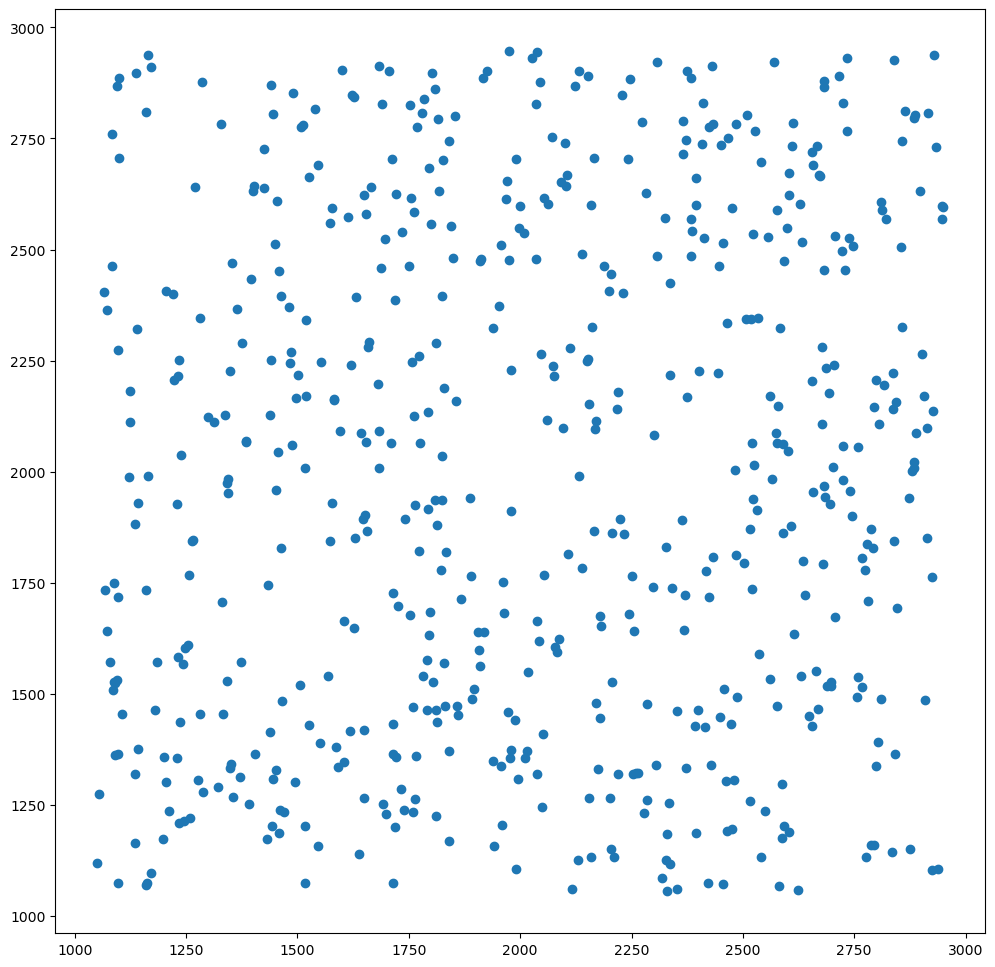

In [8]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.scatter(mock_catalog["X"], mock_catalog["Y"])

In [9]:
nimage = 1
nobj = len(fr.scat)
obj_data = meds.util.get_meds_input_struct(nobj, extra_fields=[("X_IMAGE", "f8"), ("Y_IMAGE", "f8")])
obj_data['id'] = fr.scat['NUMBER']
obj_data['box_size'] = np.ones(nobj) * 16
obj_data['ra'] = fr.scat['ALPHAWIN_J2000']
obj_data['dec'] = fr.scat['DELTAWIN_J2000']
obj_data['X_IMAGE'] = fr.scat['X_IMAGE']
obj_data['Y_IMAGE'] = fr.scat['Y_IMAGE']

In [19]:
image_info= meds.util.get_image_info_struct(nimage, 31)

image_info['image_path'][0] = './test_canvas_const.fits'
image_info['weight_path'][0] = './test_canvas_const_weight.fits' 
image_info['seg_path'][0] = './test_canvas_const_seg.fits'
image_info['magzp'] = 30.

config = {'first_image_is_coadd': False,'cutout_types':['weight', 'seg'],'psf_type':'psfex'}

In [20]:
len('./test_canvas_const_weight.fits' )

31

In [21]:
import psfex

# row=514.25
# col=610.00
pex = psfex.PSFEx("../meds/star_canvas_cat.psf")
# image = pex.get_rec(row, col)
psf_data = [pex,]

In [22]:
mm = meds.MEDSMaker(obj_data=obj_data, image_info=image_info, config=config, psf_data=psf_data)

writing cutouts for: ['image', 'weight', 'seg']


In [24]:
mm.write("testmeds_const.fits")

file    1 of    1: 'b'./test_canvas_const.fits''
    first cut:     584 of    584 objects
    second cut:    584 of    584 objects
584/584 had ncut > 0
setting start rows and pixel count
total pixels: 299008
setting psf layout for PSFEx
meds layout build time: 0.035331 seconds
opening output MEDS file: 'testmeds_const.fits'
writing object_data
writing image_info
writing metadata
    reserving image mosaic
    reserving weight mosaic
    reserving seg mosaic
    reserving psf mosaic
writing image cutouts
    1/1 image b'./test_canvas_const.fits'
    no background for image
writing weight cutouts
    1/1 weight b'./test_canvas_const_weight.fits'
writing seg cutouts
    1/1 seg b'./test_canvas_const_seg.fits'
writing psf cutouts
output is in: testmeds_const.fits


In [25]:
m = meds.MEDS('testmeds_const.fits')

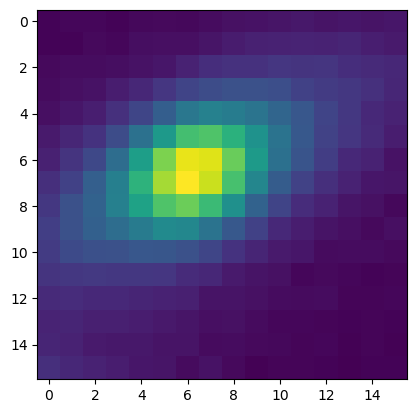

In [27]:
im = m.get_cutout(321, 0, 'image')
plt.imshow(im)

# METACAL

In [28]:

class MetacalFitter(object):
    def __init__(self, medsfile, seed=None):
        self.medsfile = medsfile

        # for some reason this is bugged if you
        self.meds = NGMixMEDS(medsfile)
        self.cat = self.meds.get_cat()
        self.Nobjs = len(self.cat)

        self.set_seed(seed)

        return

    def set_seed(self, seed=None):
        if seed is None:
            # current time in microseconds
            seed = int(1e6*time.time())

        self.seed = seed

        return

    def get_obs_list(self, iobj):
        return self.meds.get_obslist(iobj)

    def get_jacobians(self, iobj):
        Njac = len(self.meds.get_jacobian_list(iobj))

        jacobians = [self.meds.get_ngmix_jacobian(iobj, icutout)
                     for icutout in range(Njac)]

        return jacobians

    def get_obj_info(self, iobj):
        '''
        Setup object property dictionary used to compile fit params later on
        '''

        obj = self.meds[iobj]

        # Mcal object properties
        obj_info = {}

        obj_info['meds_indx'] = iobj
        obj_info['id'] = obj['id']
        obj_info['ra'] = obj['ra']
        obj_info['dec'] = obj['dec']
        obj_info['X_IMAGE'] = obj['X_IMAGE']
        obj_info['Y_IMAGE'] = obj['Y_IMAGE']

        return obj_info

    def get_prior(self, pixel_scale):
        '''
        pix_scale: The pixel scale of the image, in arcsec / pixel
        '''

        # This bit is needed for ngmix v2.x.x
        # won't work for v1.x.x
        #rng = np.random.RandomState(self.seed)

        # prior on ellipticity.  The details don't matter, as long
        # as it regularizes the fit.  This one is from Bernstein & Armstrong 2014

        g_sigma = 0.3
        g_prior = ngmix.priors.GPriorBA(g_sigma)

        # 2-d gaussian prior on the center
        # row and column center (relative to the center of the jacobian, which would be zero)
        # and the sigma of the gaussians

        # units same as jacobian, probably arcsec
        row, col = 0.0, 0.0
        row_sigma, col_sigma = pixel_scale, pixel_scale # use pixel_scale as a guess
        cen_prior = ngmix.priors.CenPrior(row, col, row_sigma, col_sigma)

        # T prior.  This one is flat, but another uninformative you might
        # try is the two-sided error function (TwoSidedErf).
        # NOTE: T units are arcsec^2 but can be slightly negative, especially for
        # stars if the PSF is mis-estimated

        Tminval = -1.0 # arcsec squared
        Tmaxval = 1000
        T_prior = ngmix.priors.FlatPrior(Tminval, Tmaxval)

        # similar for flux.  Make sure the bounds make sense for
        # your images

        Fminval = -1.e1
        Fmaxval = 1.e5
        F_prior = ngmix.priors.FlatPrior(Fminval, Fmaxval)

        # now make a joint prior.  This one takes priors
        # for each parameter separately
        prior = ngmix.joint_prior.PriorSimpleSep(
            cen_prior,
            g_prior,
            T_prior,
            F_prior
            )

        return prior

    def add_mcal_responsivities(self, mcal_res, mcal_shear):
        '''
        Compute and add the mcal responsivity values to the output
        result dict from get_metacal_result()

        NOTE: These are only for the selection-independent component!
        '''

        # Define full responsivity matrix, take inner product with shear moments
        r11 = (mcal_res['1p']['g'][0] - mcal_res['1m']['g'][0]) / (2*mcal_shear)
        r12 = (mcal_res['2p']['g'][0] - mcal_res['2m']['g'][0]) / (2*mcal_shear)
        r21 = (mcal_res['1p']['g'][1] - mcal_res['1m']['g'][1]) / (2*mcal_shear)
        r22 = (mcal_res['2p']['g'][1] - mcal_res['2m']['g'][1]) / (2*mcal_shear)

        R = [ [r11, r12], [r21, r22] ]
        Rinv = np.linalg.inv(R)
        gMC = np.dot(Rinv,
                     mcal_res['noshear']['g']
                     )

        MC = {
            'r11':r11, 'r12':r12,
            'r21':r21, 'r22':r22,
            'g1_MC':gMC[0], 'g2_MC':gMC[1]
        }

        mcal_res['MC'] = MC

        return mcal_res

    def mcal_dict2tab(self, mcal, obj_info):
        '''
        mcal is the dict returned by ngmix.get_metacal_result()

        obj_info is an array with MEDS identification info like id, ra, dec
        not returned by the function
        '''

        # Annoying, but have to do this to make Table from scalars
        for key, val in obj_info.items():
            obj_info[key] = np.array([val])

        tab_names = ['noshear', '1p', '1m', '2p', '2m','MC']
        for name in tab_names:
            tab = mcal[name]

            for key, val in tab.items():
                tab[key] = np.array([val])

            mcal[name] = tab

        id_tab = Table(data=obj_info)

        tab_noshear = Table(mcal['noshear'])
        tab_1p = Table(mcal['1p'])
        tab_1m = Table(mcal['1m'])
        tab_2p = Table(mcal['2p'])
        tab_2m = Table(mcal['2m'])
        tab_MC = Table(mcal['MC'])

        join_tab = hstack([id_tab, hstack([tab_noshear,
                                           tab_1p,
                                           tab_1m,
                                           tab_2p,
                                           tab_2m,
                                           tab_MC
                                           ],
                                          table_names=tab_names)
                           ]
                          )

        return join_tab

    def fit_obj(self, iobj, pars=None, ntry=4, psf_model='gauss',
                gal_model='gauss', vb=False):
        '''
        Run metacal fit for a single object of given index

        pars: mcal running parameters
        '''

        obj_info = self.get_obj_info(iobj)

        # Fits need a list of ngmix.Observation objects
        obs_list = self.get_obs_list(iobj)

        # Get pixel scale from image jacobian
        jac_list = self.get_jacobians(iobj)
        pixel_scale = jac_list[0].get_scale()

        if pars is None:
            # standard mcal run parameters
            mcal_shear = 0.01
            lm_pars = {'maxfev':2000, 'xtol':5.0e-5, 'ftol':5.0e-5}
            max_pars = {'method':'lm', 'lm_pars':lm_pars, 'find_center':True}
            metacal_pars = {'step':mcal_shear}
        else:
            mcal_shear = metacal_pars['step']
            max_pars = pars['max_pars']
            metacal_pars = pars['metacal_pars']

        prior = self.get_prior(pixel_scale)

        Tguess = 4*pixel_scale**2

        # setup run bootstrapper
        mcb = ngmix.bootstrap.MaxMetacalBootstrapper(obs_list)

        # Run the actual metacalibration step on the observed source
        mcb.fit_metacal(psf_model, gal_model, max_pars, Tguess, prior=prior,
                        ntry=ntry, metacal_pars=metacal_pars)

        mcal_res = mcb.get_metacal_result() # this is a dict

        # Add selection-independent responsitivities
        mcal_res = self.add_mcal_responsivities(mcal_res, mcal_shear)

        if vb is True:
            r11 = mcal_res['MC']['r11']
            r22 = mcal_res['MC']['r22']
            print(f'i={iobj}: R11: {r11:.3}; R22: {r22:.3} ')

        mcal_tab = self.mcal_dict2tab(mcal_res, obj_info)

        return mcal_tab


In [29]:
fr.scat.shape

(584,)

In [30]:

medsfile = "testmeds_const.fits"
# medsfile = "gauss_uberseg_meds.fits.fz"
outfile = "metacal_const.fits"
outdir = None
start = None
end = len(fr.scat)
clobber = True
vb = True #args.vb # if True, prints out values of R11/R22 for every galaxy

if outdir is not None:
    outfile = os.path.join(outdir, outfile)

fitter = MetacalFitter(medsfile)

if start is None:
    start = 0
if end is None:
    end = fitter.Nobjs

# Can set mcal parameters here if you want something beyond the default
# in fit_obj()
pars = None

Tstart = time.time()

mcal_tab = []
for iobj in range(start, end):
    mcal_tab.append(
        fitter.fit_obj(iobj, pars=pars, vb=vb)
        )

mcal_tab = vstack(mcal_tab)

Tend = time.time()

T = Tend - Tstart
print(f'Total fitting and stacking time: {T} seconds')

if vb is True:
    print(f'Writing out mcal results to {outfile}...')
mcal_tab.write(outfile, overwrite=clobber)

if vb is True:
    print('Done!')



/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/fitting_nb.py:169: NumbaExperimentalFeatureWarning: Record(u[type=float64;offset=0],v[type=float64;offset=8],val[type=float64;offset=16],ierr[type=float64;offset=24],fdiff[type=float64;offset=32];40;False) has been considered a subtype of Record(u[type=float64;offset=0],v[type=float64;offset=8];16;False)  This is an experimental feature.
  model_val = gmix_eval_pixel_fast(gmix, pixel)


i=0: R11: 0.987; R22: 0.756 
i=1: R11: 1.2; R22: 1.01 
i=2: R11: 1.06; R22: 0.783 
i=3: R11: 0.963; R22: 0.756 
i=4: R11: 1.27; R22: 0.899 
i=5: R11: 0.894; R22: 0.787 
i=6: R11: 1.1; R22: 0.89 
i=7: R11: 0.841; R22: 0.718 
i=8: R11: 0.829; R22: 0.715 
i=9: R11: 1.31; R22: 0.835 
i=10: R11: 1.07; R22: 0.86 
i=11: R11: 1.03; R22: 0.875 
i=12: R11: 0.806; R22: 0.72 
i=13: R11: 0.879; R22: 0.785 
i=14: R11: 0.866; R22: 0.868 
i=15: R11: 1.83; R22: 1.36 
i=16: R11: 0.972; R22: 0.723 
i=17: R11: 1.35; R22: 0.203 
i=18: R11: 0.89; R22: 0.601 
i=19: R11: 0.919; R22: 0.821 
i=20: R11: 1.37; R22: 0.945 
i=21: R11: 1.01; R22: 0.88 
i=22: R11: 1.13; R22: 0.804 
i=23: R11: 0.895; R22: 0.77 
i=24: R11: 1.04; R22: 0.852 
i=25: R11: 1.17; R22: 0.936 
i=26: R11: 1.13; R22: 0.841 
i=27: R11: 1.02; R22: 0.85 
i=28: R11: 0.942; R22: 0.754 
i=29: R11: 0.942; R22: 0.772 
i=30: R11: 0.82; R22: 0.709 
i=31: R11: 1.05; R22: 0.756 
i=32: R11: 0.998; R22: 0.873 
i=33: R11: 0.84; R22: 0.675 
i=34: R11: 0.957; R2

i=261: R11: 0.863; R22: 0.689 
i=262: R11: 1.08; R22: 0.834 
i=263: R11: 1.62; R22: 0.979 
i=264: R11: 1.97; R22: 1.81 
i=265: R11: 1.15; R22: 0.871 
i=266: R11: 1.41; R22: 0.926 
i=267: R11: 1.16; R22: 0.861 
i=268: R11: 0.923; R22: 0.78 
i=269: R11: 0.841; R22: 0.795 
i=270: R11: 1.19; R22: 0.858 
i=271: R11: 1.17; R22: 0.877 
i=272: R11: 0.926; R22: 0.765 
i=273: R11: 1.28; R22: 0.869 
i=274: R11: 1.01; R22: 0.75 
i=275: R11: 0.824; R22: 0.842 
i=276: R11: 1.07; R22: 0.857 
i=277: R11: 1.17; R22: 0.544 
i=278: R11: 0.868; R22: 0.774 
i=279: R11: 1.16; R22: 0.843 
i=280: R11: 0.964; R22: 0.828 
i=281: R11: 0.875; R22: 0.771 
i=282: R11: 1.12; R22: 0.881 
i=283: R11: 0.881; R22: 0.728 
i=284: R11: 0.998; R22: 0.781 
i=285: R11: 1.11; R22: 0.87 
i=286: R11: 1.55; R22: 1.0 
i=287: R11: 0.972; R22: 0.796 
i=288: R11: 0.492; R22: 32.5 
i=289: R11: 0.732; R22: 0.366 
i=290: R11: 0.832; R22: 0.746 
i=291: R11: 1.05; R22: 0.837 
i=292: R11: 0.944; R22: 0.777 
i=293: R11: 1.09; R22: 0.868 
i=

i=533: R11: 0.955; R22: 0.806 
i=534: R11: 1.67; R22: 0.993 
i=535: R11: 0.925; R22: 0.762 
i=536: R11: 1.27; R22: 0.925 
i=537: R11: 1.34; R22: 0.906 
i=538: R11: 1.52; R22: 1.07 
i=539: R11: 0.892; R22: 0.772 
i=540: R11: 0.88; R22: 0.765 
i=541: R11: 0.82; R22: 0.703 
i=542: R11: 1.02; R22: 0.85 
i=543: R11: 1.05; R22: 0.819 
i=544: R11: 0.833; R22: 0.815 
i=545: R11: 1.25; R22: 0.909 
i=546: R11: 0.869; R22: 0.716 
i=547: R11: 1.37; R22: 0.931 
i=548: R11: 0.941; R22: 0.783 
i=549: R11: 0.88; R22: 0.794 
i=550: R11: 0.949; R22: 0.696 
i=551: R11: 0.821; R22: 0.734 
i=552: R11: 1.17; R22: 0.874 
i=553: R11: 1.03; R22: 0.854 
i=554: R11: 1.16; R22: 0.893 
i=555: R11: 0.885; R22: 0.692 
i=556: R11: 1.2; R22: 0.842 
i=557: R11: 1.0; R22: 0.823 
i=558: R11: 0.966; R22: 0.81 
i=559: R11: 1.29; R22: 0.887 
i=560: R11: 1.27; R22: 1.11 
i=561: R11: 0.884; R22: 0.761 
i=562: R11: 1.1; R22: 0.805 
i=563: R11: 1.27; R22: 0.897 
i=564: R11: 1.01; R22: 0.861 
i=565: R11: 0.855; R22: 0.78 
i=566:

In [36]:
tab = fio.read('metacal_const.fits')

In [37]:
tab

array([(  0,   1, 90.0662268 , -6.78679411e-02,   97.46474457,   74.97648621, 0,  58, 1, 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000050', [-2.64366910e-01, -2.55216225e-01,  2.22035770e-01, -3.10459286e-01,  8.72864249e-01,  4.32822269e+02], [8.42969482e-03, 1.14004872e-02, 1.29314202e-02, 1.31393874e-02, 2.50322150e-02, 5.68908781e+00], [[ 2.04425292e-06, -1.15604935e-06,  2.59372544e-08, -1.43421097e-08,  7.73070270e-08,  1.10338583e-05], [-1.15604935e-06,  3.73901964e-06, -7.98706094e-08,  2.33088422e-08, -2.34123034e-07, -3.55122326e-05], [ 2.59372544e-08, -7.98706094e-08,  4.81064568e-06, -3.08466389e-07,  1.40514141e-06, -1.68838285e-04], [-1.43421097e-08,  2.33088422e-08, -3.08466389e-07,  4.96662258e-06, -1.60418943e-06,  3.00250563e-04], [ 7.73070270e-08, -2.34123034e-07,  1.40514141e-06, -1.60418943e-06,  1.80264198e-05,  2.65375339e-03], [ 1.10338583e-05, -3.55122326e-05, -1.68838285e-04,  3.00250563e-04,  2.65375339e-03,  9.3109

In [65]:
tab['g1_MC'].mean() / tab['r11'].mean()

0.27080124019424595

In [66]:
tab['g2_MC'].mean() / tab['r22'].mean()

-0.5616037587048422